# Simulação, Controle e Otimização de um Processo Industrial em Escala Piloto de uma Cervejaria Artesanal

## Preparar ambiente

In [25]:
#!pip install deap

import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random

## Dados do Sistema e Constantes

In [26]:
t_total = 60  # minutos
massa_agua = 25.5
massa_malte = 8.5
massa_mosto = massa_agua + massa_malte
volume_malte = 13.6
volume_mosto = massa_agua + volume_malte
c = 4.1855  # kJ/kg°C
potencia = 6  # kW

T_min, T_max = 293.15, 403.15  # K (20°C a 130°C)
T0 = 293.15  # Temperatura inicial (K)

## Funções Físico-Químicas

In [27]:
def isomerizacao(T):
    return 7.9e11 * np.exp(-11858 / T)

def calcular_iso_total(T, time_step):
    T_iso = T[(T >= 363.15) & (T <= 403.15)]
    if len(T_iso) == 0:
        return 0
    taxas = isomerizacao(T_iso)
    return np.sum(taxas * time_step)

def calcular_energia_fornecida():
    return potencia * t_total * 60  # kJ

def energia_usada(delta_T):
    return c * massa_mosto * np.sum(delta_T)

def calcular_massa_evaporada(delta_T):
    energia_restante = calcular_energia_fornecida() - energia_usada(delta_T)
    h = 2257  # kJ/kg (entalpia de vaporização da água a 100°C)
    return energia_restante / h

def calcular_energia_termica_total(T):
    delta_T = np.diff(T, prepend=T0)
    return energia_usada(delta_T), delta_T

def calcular_densidade(massa_evaporada):
    massa_restante = massa_mosto - massa_evaporada
    volume_restante = volume_mosto - massa_evaporada
    return massa_restante / volume_restante

def calcular_penalizacao_densidade(densidade, faixa=(1000, 1025)):
    min_d, max_d = faixa
    if min_d <= densidade <= max_d:
        return 0
    desvio = min(abs(densidade - min_d), abs(densidade - max_d))
    return desvio / ((min_d + max_d) / 2)


## Função Objetivo

A entrada de temperatura (ou seja, os valores de T) precisa ter espaços de tempo equivalentes.

In [28]:
def func_objetivo_deap(individual):
    T = np.clip(np.array(individual), T_min, T_max)
    time_step = 60 / len(T)
    
    energia_total, delta_T = calcular_energia_termica_total(T)
    massa_evaporada = calcular_massa_evaporada(delta_T)
    iso_total = calcular_iso_total(T, time_step)
    densidade = calcular_densidade(massa_evaporada)

    energia_norm = energia_total / 10000
    iso_norm = iso_total / 1.0
    evap_norm = massa_evaporada / massa_mosto
    penalizacao_densidade = calcular_penalizacao_densidade(densidade)

    # Pesos, de acordo com o objetivo (Minimizar energia e evaporação, maximizar isomerização e regular a densidade), seção 3.3.3.(CONTROLE ÓTIMO MULTIOBJETIVO UTILIZANDO ALGORITMO GENÉTICO)
    w1, w2, w3, w4 = -1, -1, 1, 1

    score = (
        w1 * energia_norm +
        w3 * evap_norm +
        w4 * penalizacao_densidade -
        w2 * iso_norm
    )
    return (score,)


## Configurações DEAP

In [29]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, T_min, T_max)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=t_total)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", func_objetivo_deap)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=5, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

## Resultados

In [30]:
population = toolbox.population(n=50)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

population, logbook = algorithms.eaSimple(
    population, toolbox,
    cxpb=0.5, mutpb=0.2, ngen=40,
    stats=stats, halloffame=hof,
    verbose=True
)

gen	nevals	avg    	std     	min      	max    
0  	50    	1.16334	0.528911	0.0763628	2.49911
1  	25    	0.842914	0.383641	0.278155 	1.63746
2  	24    	0.597957	0.314465	0.144448 	1.81929
3  	32    	0.410905	0.168729	0.053463 	0.956441
4  	31    	0.333146	0.154123	-0.0532345	0.6988  
5  	28    	0.242305	0.13562 	-0.0532345	0.671778
6  	34    	0.177597	0.142076	-0.109336 	0.609628
7  	26    	0.0722587	0.118244	-0.134688 	0.431276
8  	28    	0.00345289	0.110215	-0.160671 	0.501907
9  	31    	-0.0370368	0.0852963	-0.232375 	0.269171
10 	27    	-0.065699 	0.0760468	-0.232375 	0.176329
11 	32    	-0.0873063	0.092297 	-0.230554 	0.175604
12 	31    	-0.14509  	0.0762094	-0.252298 	0.085238
13 	33    	-0.183862 	0.048952 	-0.266604 	0.0275474
14 	35    	-0.199109 	0.063615 	-0.284359 	0.0610384
15 	31    	-0.231426 	0.0351787	-0.28488  	-0.114538
16 	31    	-0.253288 	0.0329942	-0.309823 	-0.154477
17 	34    	-0.268678 	0.0491847	-0.324078 	-0.0149045
18 	38    	-0.285526 	0.0413381	-0.327938 	-

In [31]:
melhor_ind = hof[0]
melhor_T = np.clip(melhor_ind, T_min, T_max)
energia_total, delta_T = calcular_energia_termica_total(melhor_T)
massa_evaporada = calcular_massa_evaporada(delta_T)
iso_total = calcular_iso_total(np.array(melhor_T), 60/len(melhor_T))
densidade = calcular_densidade(massa_evaporada)

print("Temperaturas ótimas:", melhor_T)
print("Energia total:", energia_total)
print("Massa evaporada:", massa_evaporada)
print("Isomerização total:", iso_total)
print("Densidade final:", densidade)

Temperaturas ótimas: [361.61966955 332.64466921 344.14210194 316.06797112 359.01157339
 352.31894483 356.47046393 342.32863374 317.15027276 314.29697399
 327.10099009 350.920269   325.93542501 320.42959171 331.8577795
 329.62616464 357.44420001 293.15       324.17714378 355.1970671
 329.73660921 293.15       333.85249205 358.92792942 312.51403528
 362.41396154 319.8539807  361.81472873 313.8367615  320.17193822
 357.67117746 333.19952991 361.56097204 341.35972235 293.15
 337.00923453 357.03610324 349.22694862 315.12473875 340.71103308
 362.4680724  293.15       327.88938787 331.94135319 343.34133078
 298.11928747 335.79390003 336.18477474 346.10120545 361.0480868
 355.79997056 330.69417682 347.33078617 350.62208637 330.99588991
 316.18048367 346.80915773 293.15       333.30693556 403.15      ]
Energia total: 15653.770000000002
Massa evaporada: 2.6345724412937517
Isomerização total: 0.13291161359703516
Densidade final: 0.8601415000060143


### Vizualização

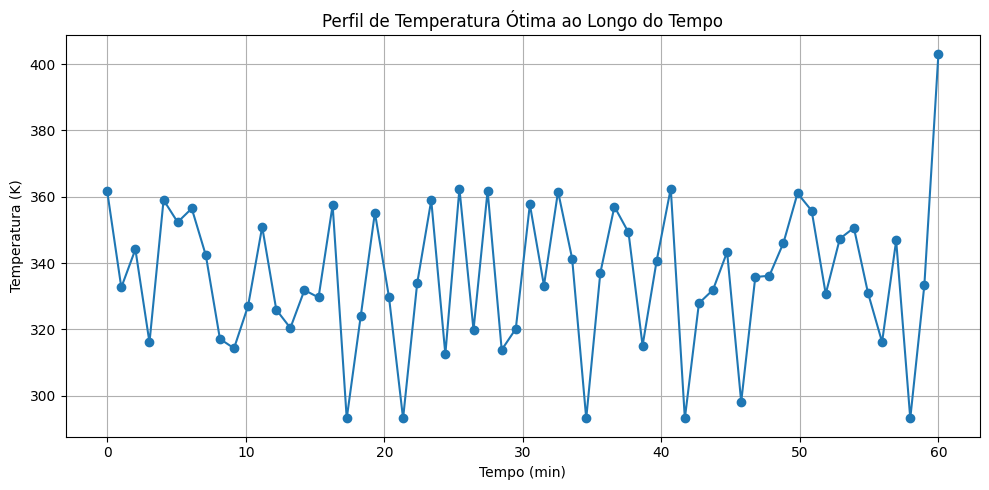

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, 60, t_total), melhor_T, marker='o', linestyle='-')
plt.title("Perfil de Temperatura Ótima ao Longo do Tempo")
plt.xlabel("Tempo (min)")
plt.ylabel("Temperatura (K)")
plt.grid(True)
plt.tight_layout()
plt.show()